In [8]:
import PyPDF2
import re
import smtplib
import os
from email.message import EmailMessage
from typing import TypedDict, Optional

from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from sentence_transformers import SentenceTransformer, util
from langchain_groq import ChatGroq

In [2]:
load_dotenv()

True

In [3]:
@tool
def extract_text_from_pdf(pdf_path: str) -> dict:
    """Extract text and email address from a PDF resume."""
    try:
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            text = ""
            for page in reader.pages:
                text += page.extract_text() or "" 

        email_match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
        email = email_match.group(0) if email_match else ""

        print(f"✅ PDF Extracted: {bool(text)} | Email Found: {bool(email)}")
        return {"resume_text": text, "email": email, "extraction_error": False, "error_message": ""}

    except Exception as e:
        print(f"❌ Error extracting text from PDF '{pdf_path}': {e}")
        return {"resume_text": "", "email": "", "extraction_error": True, "error_message": str(e)}

try:
    model = SentenceTransformer('all-MiniLM-L6-v2')
    print("✅ SentenceTransformer model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading SentenceTransformer model: {e}")
    model = None 

✅ SentenceTransformer model loaded successfully.


In [4]:
@tool
def llm_ats_score(resume_text: str, job_text: str) -> dict:
    """
    Compute semantic similarity between resume and job description using embeddings.
    Returns an ATS score between 0–100.
    """
    if not model:
        return {"ats_score": 0.0, "scoring_error": True, "error_message": "SentenceTransformer model not loaded."}
    
    try:
        embeddings = model.encode([resume_text, job_text])
        similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
        score = round(similarity * 100, 2)
        print(f"✅ ATS Score Computed: {score}")
        return {"ats_score": score, "scoring_error": False, "error_message": ""}
    except Exception as e:
        print(f"❌ Semantic scoring failed: {e}")
        return {"ats_score": 0.0, "scoring_error": True, "error_message": str(e)}


In [5]:
@tool
def send_rejection_email(email: str) -> dict:
    """Send a polite rejection email if ATS score is low."""
    sender = os.getenv("EMAIL_SENDER")
    password = os.getenv("EMAIL_PASSWORD")

    if not sender or not password:
        print("❌ Email sender or password not configured in .env")
        return {"email_sent": False, "email_error": True, "error_message": "Email credentials missing."}

    try:
        msg = EmailMessage()
        msg["Subject"] = "Regarding Your Job Application"
        msg["From"] = sender
        msg["To"] = email
        msg.set_content("Thank you for your application. We regret to inform you that we will not be moving forward with your application at this time. Please feel free to reapply in the future if your qualifications align with our future openings. Best wishes!")

        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender, password)
            server.send_message(msg)
        print(f"✅ Rejection email sent to: {email}")
        return {"email_sent": True, "email_error": False, "error_message": ""}
    except Exception as e:
        print(f"❌ Error sending rejection email to {email}: {e}")
        return {"email_sent": False, "email_error": True, "error_message": str(e)}


In [6]:
@tool
def send_acceptance_email(email: str) -> dict:
    """Send an acceptance email for further steps."""
    sender = os.getenv("EMAIL_SENDER")
    password = os.getenv("EMAIL_PASSWORD")

    if not sender or not password:
        print("❌ Email sender or password not configured in .env")
        return {"email_sent": False, "email_error": True, "error_message": "Email credentials missing."}

    try:
        msg = EmailMessage()
        msg["Subject"] = "Exciting News Regarding Your Job Application!"
        msg["From"] = sender
        msg["To"] = email
        msg.set_content("Great news! We're impressed with your application and would like to invite you for an interview. Please expect a follow-up email with scheduling details shortly. We look forward to speaking with you!")

        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender, password)
            server.send_message(msg)
        print(f"✅ Acceptance email sent to: {email}")
        return {"email_sent": True, "email_error": False, "error_message": ""}
    except Exception as e:
        print(f"❌ Error sending acceptance email to {email}: {e}")
        return {"email_sent": False, "email_error": True, "error_message": str(e)}

In [9]:
llm = ChatGroq(model="gemma2-9b-it", temperature=0.2,api_key=os.getenv("GROQ_API_KEY"))

summary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an HR assistant. Summarize the following resume for a quick review, highlighting key skills and experience relevant to the job description."),
    ("user", "Resume:\n{resume_text}\n\nJob Description:\n{job_text}")
])
resume_summarizer = summary_prompt | llm | StrOutputParser()


In [10]:
class HRApplicationState(TypedDict):
    pdf_path: str
    resume_text: str
    email: str
    job_text: str
    ats_score: float
    resume_summary: Optional[str] # New field for LLM summary
    # Error tracking fields
    extraction_error: bool
    scoring_error: bool
    email_error: bool
    error_message: Optional[str] # Det

In [11]:
def _extract_resume_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: extract_resume --- Processing {state.get('pdf_path', 'N/A')}")
    pdf_path = state["pdf_path"]
    extracted_data = extract_text_from_pdf.invoke({"pdf_path": pdf_path})
    return {**extracted_data} 

def _ats_scorer_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: ats_scorer ---")
    if state.get("extraction_error"):
        print("Skipping ATS scoring due to prior extraction error.")
        return {"scoring_error": True, "error_message": "Skipped due to extraction error."} # Propagate error
        
    resume_text = state.get("resume_text", "")
    job_text = state.get("job_text", "")

    if not resume_text or not job_text:
        print("Error: 'resume_text' or 'job_text' is missing for ATS scoring.")
        return {"ats_score": 0.0, "scoring_error": True, "error_message": "'resume_text' or 'job_text' missing for ATS scoring."}
    
    score_data = llm_ats_score.invoke({
        "resume_text": resume_text,
        "job_text": job_text
    })
    return {**score_data} # Merge score and error status

def _summarize_resume_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: summarize_resume ---")
    if state.get("extraction_error") or state.get("scoring_error"):
        print("Skipping resume summarization due to prior errors.")
        return {"resume_summary": None}

    resume_text = state.get("resume_text", "")
    job_text = state.get("job_text", "")

    if not resume_text or not job_text:
        print("Error: 'resume_text' or 'job_text' missing for summarization.")
        return {"resume_summary": None, "error_message": "'resume_text' or 'job_text' missing for summarization."}

    try:
        summary = resume_summarizer.invoke({
            "resume_text": resume_text,
            "job_text": job_text
        })
        print("✅ Resume summarized.")
        return {"resume_summary": summary}
    except Exception as e:
        print(f"❌ Error summarizing resume: {e}")
        return {"resume_summary": None, "error_message": str(e)}


In [12]:
def _send_rejection_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: send_rejection ---")
    if state.get("email_error"): # Check if email sending itself has a problem (e.g. creds)
         print("Skipping rejection email due to prior email configuration error.")
         return {}
    
    email = state.get("email")
    if not email:
        print("Skipping rejection email: No email address found.")
        return {"email_error": True, "error_message": "No email address found for rejection."}

    email_sent_data = send_rejection_email.invoke({"email": email})
    return {**email_sent_data}

def _send_acceptance_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: send_acceptance ---")
    if state.get("email_error"):
         print("Skipping acceptance email due to prior email configuration error.")
         return {}
         
    email = state.get("email")
    if not email:
        print("Skipping acceptance email: No email address found.")
        return {"email_error": True, "error_message": "No email address found for acceptance."}

    email_sent_data = send_acceptance_email.invoke({"email": email})
    return {**email_sent_data}

In [13]:
def _human_review_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: human_review ---")
    print("\n--- CANDIDATE FOR HUMAN REVIEW ---")
    print(f"Email: {state.get('email', 'N/A')}")
    print(f"ATS Score: {state.get('ats_score', 'N/A')}")
    print(f"Resume Summary:\n{state.get('resume_summary', 'No summary available.')}\n")
    print("----------------------------------")
    # In a real application, this would trigger a notification, save to a
    # pending review queue in a database, etc.
    return {}

def _handle_error_node(state: HRApplicationState) -> HRApplicationState:
    print(f"--- Node: handle_error ---")
    print(f"\n--- WORKFLOW ERROR ENCOUNTERED ---")
    if state.get("extraction_error"):
        print(f"Extraction Error: {state.get('error_message', 'Unknown extraction error')}")
    if state.get("scoring_error"):
        print(f"Scoring Error: {state.get('error_message', 'Unknown scoring error')}")
    if state.get("email_error"):
        print(f"Email Error: {state.get('error_message', 'Unknown email error')}")
    print("Application processing terminated due to errors.")
    print("----------------------------------")
    # This node could send an alert to HR, log to an error tracking system, etc.
    return {}

In [14]:
workflow = StateGraph(HRApplicationState)

# Add nodes as callables
workflow.add_node("extract_resume", _extract_resume_node)
workflow.add_node("ats_scorer", _ats_scorer_node)
workflow.add_node("summarize_resume", _summarize_resume_node)
workflow.add_node("send_rejection", _send_rejection_node)
workflow.add_node("send_acceptance", _send_acceptance_node)
workflow.add_node("human_review", _human_review_node)
workflow.add_node("handle_error", _handle_error_node)


In [15]:
workflow.set_entry_point("extract_resume")

# Conditional edge after resume extraction (check for errors)
def check_extraction_status(state: HRApplicationState) -> str:
    if state.get("extraction_error"):
        return "handle_error" # Route to error handler if extraction failed
    return "ats_scorer" # Continue to ATS scorer

workflow.add_conditional_edges(
    "extract_resume",
    check_extraction_status,
    {
        "handle_error": "handle_error",
        "ats_scorer": "ats_scorer",
    }
)

# Conditional edge after ATS scoring (check for errors)
def check_scoring_status(state: HRApplicationState) -> str:
    if state.get("scoring_error"):
        return "handle_error" # Route to error handler if scoring failed
    return "summarize_resume" # Continue to summarization

workflow.add_conditional_edges(
    "ats_scorer",
    check_scoring_status,
    {
        "handle_error": "handle_error",
        "summarize_resume": "summarize_resume",
    }
)


In [16]:
# Decision logic after ATS scoring and summarization
def decide_next(state: HRApplicationState) -> str:
    print(f"--- Node: decide_next (ATS Score: {state.get('ats_score', 'N/A')}) ---")
    
    # If any prior critical error, route to error handler (redundant but safe)
    if state.get("extraction_error") or state.get("scoring_error"):
        return "handle_error"

    score = state.get("ats_score", 0.0) # Default to 0.0 if not set

    # Define thresholds
    REJECTION_THRESHOLD = 60
    HUMAN_REVIEW_THRESHOLD = 75

    if score < REJECTION_THRESHOLD:
        return "send_rejection"
    elif REJECTION_THRESHOLD <= score < HUMAN_REVIEW_THRESHOLD:
        return "human_review"
    else: # score >= HUMAN_REVIEW_THRESHOLD
        return "send_acceptance"

workflow.add_conditional_edges(
    "summarize_resume", # Decision happens after summarization
    decide_next,
    {
        "send_rejection": "send_rejection",
        "human_review": "human_review",
        "send_acceptance": "send_acceptance",
        "handle_error": "handle_error", # Catch potential LLM errors in summarization
    }
)

# Define final edges to END or error handler
workflow.add_edge("send_rejection", END)
workflow.add_edge("send_acceptance", END)
workflow.add_edge("human_review", END) # Human review is the end of this automated part
workflow.add_edge("handle_error", END) # Errors also lead to END after logging


# Compile the workflow
app = workflow.compile()

Graph visualization generated. Displaying...


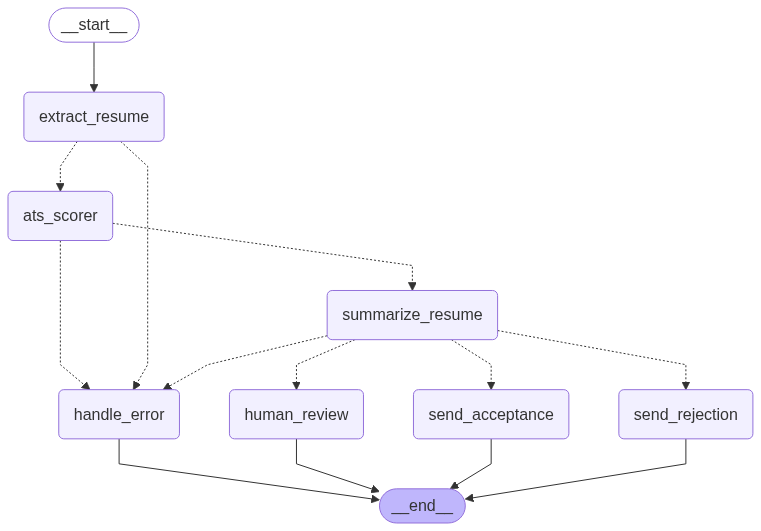

In [17]:
# --- Visualization (Requires graphviz and pydot to be installed) ---
try:
    from IPython.display import Image, display
    graph_image = app.get_graph().draw_mermaid_png()
    print("Graph visualization generated. Displaying...")
    display(Image(graph_image))
except ImportError:
    print("Install 'graphviz' and 'pydotplus' (`pip install graphviz pydotplus`) for graph visualization.")
    print("You might also need to install Graphviz system-wide.")
except Exception as e:
    print(f"Could not generate graph visualization: {e}")

In [18]:
if __name__ == "__main__":
    # Ensure a 'new_resume.pdf' exists for testing
    pdf_file_path = "new_resume.pdf" 
    # This job description will influence the ATS score and summary
    job_description_text = (
        "We are seeking a highly motivated Software Engineer with 3+ years of experience "
        "in Python, machine learning (PyTorch/TensorFlow), and cloud platforms (AWS/Azure). "
        "Experience with NLP and large language models is a plus."
    )

    initial_state = {
        'pdf_path': pdf_file_path,
        'job_text': job_description_text,
        # Initialize other fields with default empty values
        'resume_text': '',
        'email': '',
        'ats_score': 0.0,
        'resume_summary': None,
        'extraction_error': False,
        'scoring_error': False,
        'email_error': False,
        'error_message': None,
    }

In [20]:
print(f"\n--- Invoking application for PDF: {pdf_file_path} ---")
final_state = app.invoke(initial_state)
print("\n--- Final State of the Application ---")
print(f"PDF Path: {final_state.get('pdf_path')}")
print(f"Resume Text Extracted: {bool(final_state.get('resume_text'))}")
print(f"Email Found: {final_state.get('email', 'N/A')}")
print(f"ATS Score: {final_state.get('ats_score', 'N/A')}")
print(f"Resume Summary:\n{final_state.get('resume_summary', 'N/A')}")
print(f"Extraction Error: {final_state.get('extraction_error')}")
print(f"Scoring Error: {final_state.get('scoring_error')}")
print(f"Email Error: {final_state.get('email_error')}")
print(f"Last Error Message: {final_state.get('error_message', 'None')}")

# You can run with a non-existent PDF to test error handling
print("\n--- Testing with a non-existent PDF for error handling ---")
error_state_input = initial_state.copy()
error_state_input['pdf_path'] = "non_existent_resume.pdf"
error_final_state = app.invoke(error_state_input)
print("\n--- Final State for Error Test ---")
print(f"PDF Path: {error_final_state.get('pdf_path')}")
print(f"Extraction Error: {error_final_state.get('extraction_error')}")
print(f"Last Error Message: {error_final_state.get('error_message', 'None')}")
print(f"ATS Score: {error_final_state.get('ats_score', 'N/A')}")
print(f"Resume Summary: {error_final_state.get('resume_summary', 'N/A')}")
print(f"Email Error: {error_final_state.get('email_error')}")


--- Invoking application for PDF: new_resume.pdf ---
--- Node: extract_resume --- Processing new_resume.pdf
✅ PDF Extracted: True | Email Found: True
--- Node: ats_scorer ---
✅ ATS Score Computed: 59.56
--- Node: summarize_resume ---
✅ Resume summarized.
--- Node: decide_next (ATS Score: 59.56) ---
--- Node: send_rejection ---
✅ Rejection email sent to: lingeswaranmithurshan222@gmail.com

--- Final State of the Application ---
PDF Path: new_resume.pdf
Resume Text Extracted: True
Email Found: lingeswaranmithurshan222@gmail.com
ATS Score: 59.56
Resume Summary:
## Lingeswaran Mithurshan - Quick Resume Review

**Key Skills & Experience:**

* **Strong Python foundation:**  Proficient in Python with experience in machine learning libraries like TensorFlow, Scikit-learn, and NLP tools like Hugging Face and LangChain.
* **Machine Learning Expertise:**  Developed 5+ ML models demonstrating experience in various ML techniques and achieving performance improvements.
* **LLM Experience:**  Built 